<a href="https://colab.research.google.com/github/DinRazar/universite/blob/main/%D0%A0%D0%B0%D0%B1%D0%BE%D1%82%D0%B0_10_%D1%81_%D1%80%D0%B0%D1%81%D1%82%D1%80%D0%BE%D0%B2%D1%8B%D0%BC%D0%B8_%D0%B4%D0%B0%D0%BD%D0%BD%D1%8B%D0%BC%D0%B8_%D0%B2_Rasterio.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Практическая работа №3. Работа с растровыми данными в Rasterio**

---

**Данные для обработки:**

- Одноканальное изображение (ЦМР): https://github.com/opengeos/datasets/releases/download/raster/dem_90m.tif
- Мультиспектральное изображение (Landsat): https://github.com/opengeos/datasets/releases/download/raster/cog.tif

### **Задание 1. Чтение и исследование растровых данных**



In [1]:
import rasterio
import matplotlib.pyplot as plt

1. Откройте одноканальное изображение ЦМР с использованием `rasterio`.


In [2]:
dem_url = "https://github.com/opengeos/datasets/releases/download/raster/dem_90m.tif"
with rasterio.open(dem_url) as dem:
    dem_data = dem.read(1)  # чтение первого (и единственного) канала
    meta = dem.meta

2. Извлеките и выведите метаданные растра, включая СК, разрешение, границы, количество каналов и типы данных.


In [3]:
print("Метаданные ЦМР:")
for key, value in meta.items():
    print(f"{key}: {value}")

Метаданные ЦМР:
driver: GTiff
dtype: int16
nodata: None
width: 4269
height: 3113
count: 1
crs: EPSG:3857
transform: | 90.00, 0.00,-13442488.34|
| 0.00,-90.00, 4668371.58|
| 0.00, 0.00, 1.00|


3. Отобразите ширину и высоту растра, а также типы данных пикселей, чтобы понять размеры сетки и структуру данных.

In [4]:
print(f"Ширина (колонок): {meta['width']}")
print(f"Высота (строк): {meta['height']}")
print(f"Тип данных: {meta['dtype']}")

Ширина (колонок): 4269
Высота (строк): 3113
Тип данных: int16


---



### **Задание 2. Визуализация и манипулирование растровыми каналами**



In [5]:
import numpy as np

1. Визуализируйте одноканальное изображение ЦМР с использованием пользовательской цветовой карты (например, cmap='terrain').


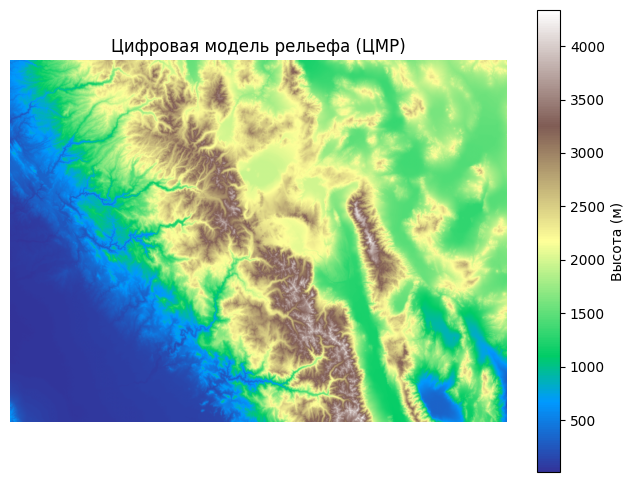

In [6]:
plt.figure(figsize=(8, 6))
plt.imshow(dem_data, cmap='terrain')
plt.colorbar(label='Высота (м)')
plt.title("Цифровая модель рельефа (ЦМР)")
plt.axis('off')
plt.show()

2. Откройте мультиспектральное изображение и визуализируйте первый канал с использованием подходящей цветовой карты.


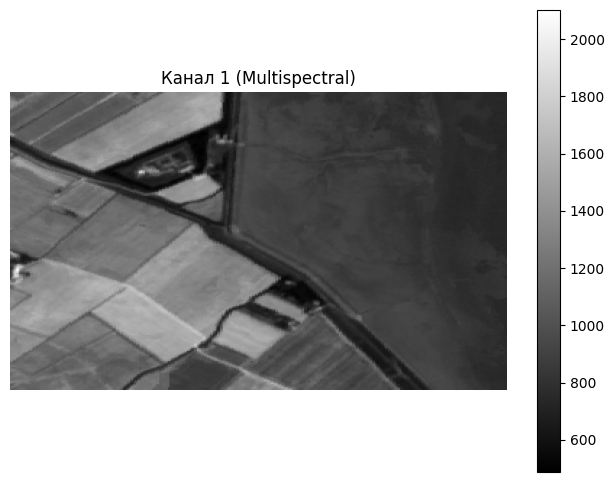

In [7]:
multispectral_url = "https://github.com/opengeos/datasets/releases/download/raster/cog.tif"
with rasterio.open(multispectral_url) as src:
    channel1 = src.read(1)

plt.figure(figsize=(8, 6))
plt.imshow(channel1, cmap='gray')
plt.colorbar()
plt.title("Канал 1 (Multispectral)")
plt.axis('off')
plt.show()

3. Объедините несколько каналов из мультиспектрального изображения (например, Красный, Зеленый и Синий) и совместите их в один массив для создания RGB-композитного изображения.

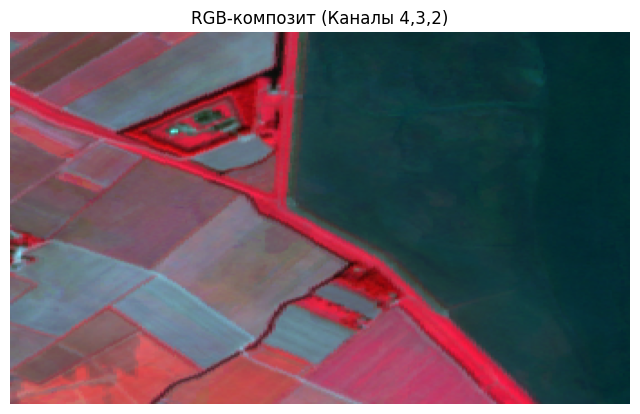

In [8]:
with rasterio.open(multispectral_url) as src:
    red = src.read(4)   # Красный
    green = src.read(3) # Зеленый
    blue = src.read(2)  # Синий

# Нормализация для улучшения визуализации
def normalize(band):
    band_min = band.min()
    band_max = band.max()
    return (band - band_min) / (band_max - band_min + 1e-9)

rgb = np.dstack((normalize(red), normalize(green), normalize(blue)))

plt.figure(figsize=(8, 6))
plt.imshow(rgb)
plt.title("RGB-композит (Каналы 4,3,2)")
plt.axis('off')
plt.show()

---



### **Задание 3. Обрезка растра с использованием индексации массива**



1. Откройте мультиспектральное изображение и обрежьте его с использованием спискового среза (указав диапазоны строк и столбцов).


In [13]:
# Функция для нормализации канала в диапазон от 0 до 1
def normalize(band):
    band_min = band.min()
    band_max = band.max()
    band_norm = (band - band_min) / (band_max - band_min)
    return band_norm

# 1. Откройте мультиспектральное изображение и обрежьте его
with rasterio.open(multispectral_url) as src:
    # Сначала получим размеры изображения
    height, width = src.height, src.width
    print(f"Размер исходного изображения: {width}x{height}")

    # Определяем безопасные координаты для обрезки (убедимся, что не выходим за границы)
    start_x = min(500, width - 500)
    start_y = min(500, height - 500)
    size = 500

    # Обрезка области 500x500 пикселей
    window = rasterio.windows.Window(start_x, start_y, size, size)
    clipped_data = src.read(window=window)

    # Сохраняем метаданные для обрезанного изображения
    meta_clipped = src.meta.copy()

Размер исходного изображения: 343x206


2. Визуализируйте обрезанную часть изображения с использованием matplotlib, чтобы убедиться в корректном результате.


>*Примечание:*
>
> При работе с многоканальными растровыми изображениями, особенно в формате COG.TIFF (Cloud Optimized GeoTIFF), может возникнуть проблема с некорректным отображением псевдоцветного изображения. Это связано с тем, что разные каналы могут иметь различные диапазоны значений пикселей.
>
> Для корректной визуализации на шаге 2 необходимо применить нормализацию к каждому каналу перед отображением.



Включите следующую функцию в ваш код:

```python
# Функция для нормализации канала в диапазон от 0 до 1
def normalize(band):
    band_min = band.min()
    band_max = band.max()
    band_norm = (band - band_min) / (band_max - band_min)
    return band_norm
```

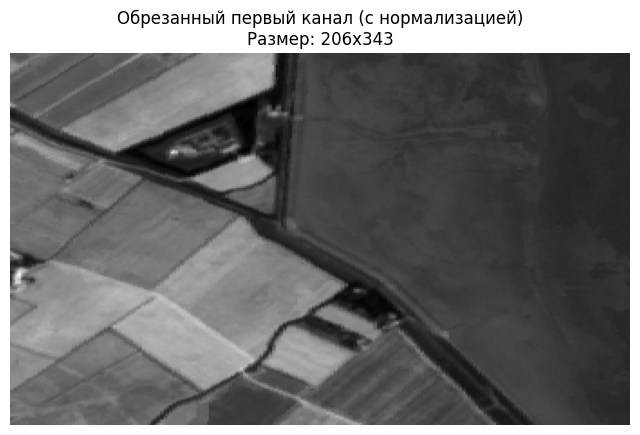

In [14]:
if clipped_data.size > 0:
    # Применяем нормализацию к первому каналу
    clipped_channel1_norm = normalize(clipped_data[0])

    plt.figure(figsize=(8, 6))
    plt.imshow(clipped_channel1_norm, cmap='gray')
    plt.title(f"Обрезанный первый канал (с нормализацией)\nРазмер: {clipped_data.shape[1]}x{clipped_data.shape[2]}")
    plt.axis('off')
    plt.show()
else:
    print("Ошибка: обрезанный массив пуст")

3. Сохраните обрезанное подмножество растра в новый файл с именем `clipped_multispectral.tif`.

In [15]:
if clipped_data.size > 0:
    # Обновляем метаданные для обрезанного изображения
    meta_clipped.update({
        "height": clipped_data.shape[1],
        "width": clipped_data.shape[2],
        "transform": rasterio.windows.transform(window, src.transform)
    })

    with rasterio.open('clipped_multispectral.tif', 'w', **meta_clipped) as dst:
        dst.write(clipped_data)

    print(f"Обрезанный растр сохранен как clipped_multispectral.tif")
    print(f"Размер обрезанного изображения: {clipped_data.shape}")

Обрезанный растр сохранен как clipped_multispectral.tif
Размер обрезанного изображения: (4, 206, 343)


---



### **Задание 4. Вычисление NDWI (калькуляция каналов)**



1. Откройте мультиспектральное изображение и извлеките каналы Green (Зеленый) и Ближний инфракрасный (NIR).


In [18]:
with rasterio.open(multispectral_url) as src:
    print(f"Количество каналов в изображении: {src.count}")

    # Проверим, какие каналы доступны
    for i in range(1, src.count + 1):
        band = src.read(i)
        print(f"Канал {i}: min={band.min()}, max={band.max()}, dtype={band.dtype}")

    green = src.read(2).astype(float)  # Зеленый канал (канал 2)
    nir = src.read(4).astype(float)    # Ближний инфракрасный (канал 4)

Количество каналов в изображении: 4
Канал 1: min=488.0, max=2102.0, dtype=float64
Канал 2: min=735.0, max=1960.0, dtype=float64
Канал 3: min=913.5, max=2083.0, dtype=float64
Канал 4: min=336.5, max=4269.0, dtype=float64


2. Вычислите Нормализованный разностный водный индекс ([NDWI](https://en.wikipedia.org/wiki/Normalized_difference_water_index)) по формуле:

    NDWI = (Green - NIR) / (Green + NIR)

In [19]:
ndwi = (green - nir) / (green + nir + 1e-9)

3. Визуализируйте результат NDWI с использованием цветовой карты, подходящей для воды (например, cmap='Blues'), чтобы выделить водные объекты.


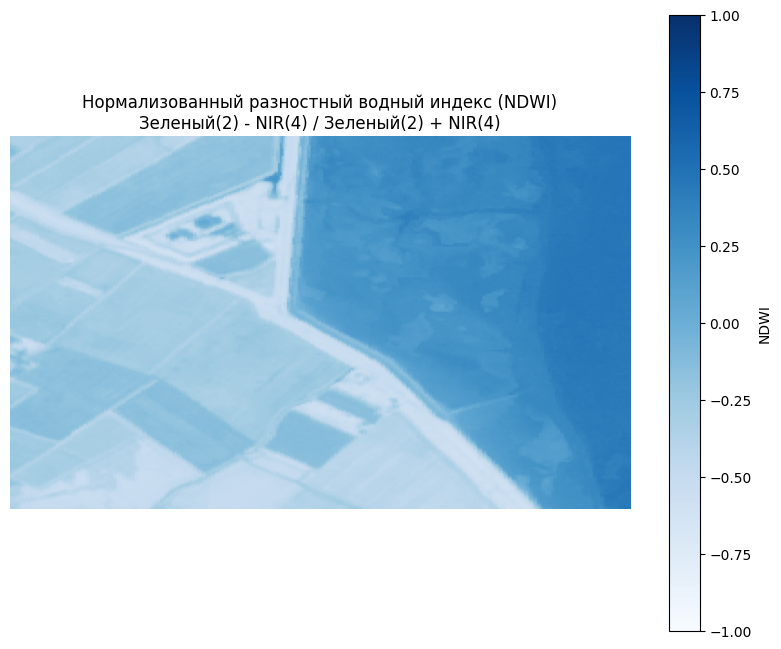

In [20]:
plt.figure(figsize=(10, 8))
plt.imshow(ndwi, cmap='Blues', vmin=-1, vmax=1)
plt.colorbar(label='NDWI')
plt.title("Нормализованный разностный водный индекс (NDWI)\nЗеленый(2) - NIR(4) / Зеленый(2) + NIR(4)")
plt.axis('off')
plt.show()



4. Сохраните полученное изображение NDWI как новый растровый файл с именем ndwi.tif.

In [21]:
with rasterio.open(multispectral_url) as src:
    meta_ndwi = src.meta.copy()
    meta_ndwi.update({
        'dtype': 'float32',
        'count': 1,
        'nodata': None
    })

with rasterio.open('ndwi.tif', 'w', **meta_ndwi) as dst:
    dst.write(ndwi.astype('float32'), 1)

print("NDWI сохранен как ndwi.tif")

NDWI сохранен как ndwi.tif


---



### **Задание 5. Перепроецирование растровых данных**



In [22]:
from rasterio.warp import calculate_default_transform, reproject, Resampling

1. Перепроецируйте одноканальный растр ЦМР из его исходной СК в EPSG:4326 (WGS 84) с использованием функции `rasterio.warp.reproject`.


In [24]:
with rasterio.open(dem_url) as src:
    # Рассчитываем параметры для перепроецирования
    transform, width, height = calculate_default_transform(
        src.crs,
        'EPSG:4326',
        src.width,
        src.height,
        *src.bounds
    )

    # Обновляем метаданные
    meta_reprojected = src.meta.copy()
    meta_reprojected.update({
        'crs': 'EPSG:4326',
        'transform': transform,
        'width': width,
        'height': height
    })

    # Создаем массив для перепроецированных данных
    reprojected_data = np.zeros((height, width), dtype=src.meta['dtype'])

    # Выполняем перепроецирование
    reproject(
        source=src.read(1),
        destination=reprojected_data,
        src_transform=src.transform,
        src_crs=src.crs,
        dst_transform=transform,
        dst_crs='EPSG:4326',
        resampling=Resampling.bilinear
    )

2. Сохраните перепроецированный растр в новый файл GeoTIFF с именем `reprojected_dem.tif`.


In [25]:
with rasterio.open('reprojected_dem.tif', 'w', **meta_reprojected) as dst:
    dst.write(reprojected_data, 1)

print("Перепроецированный растр сохранен как reprojected_dem.tif")

Перепроецированный растр сохранен как reprojected_dem.tif


3. Визуализируйте как исходный, так и перепроецированный наборы данных ЦМР, чтобы сравнить, как перепроецирование влияет на пространственное покрытие и разрешение.

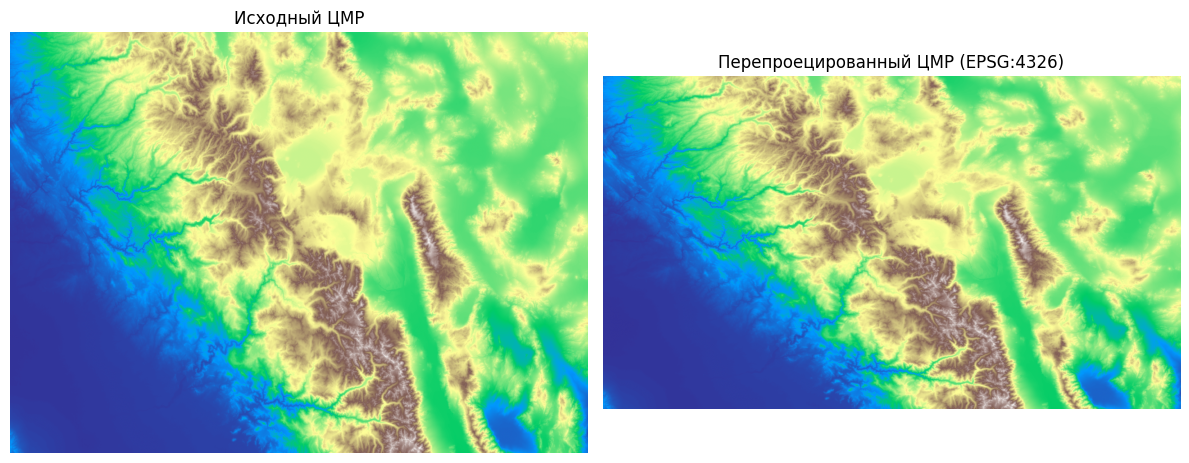

In [26]:
fig, axes = plt.subplots(1, 2, figsize=(12, 5))

axes[0].imshow(dem_data, cmap='terrain')
axes[0].set_title("Исходный ЦМР")
axes[0].axis('off')

axes[1].imshow(reprojected_data, cmap='terrain')
axes[1].set_title("Перепроецированный ЦМР (EPSG:4326)")
axes[1].axis('off')

plt.tight_layout()
plt.show()

---